In [8]:
import numpy as np
import matplotlib.pyplot as plt
import string
import random
import re,os
import requests
import textwrap

In [9]:
#create a substitution cypher
letters1=list(string.ascii_lowercase)
letters2=list(string.ascii_lowercase)

true_mapping={}

random.shuffle(letters2)
for k,v in zip(letters1,letters2):
  true_mapping[k]=v

In [10]:
# language model
## Initialization

M=np.ones((26,26))
pi=np.zeros((26))

def update_transition(ch1,ch2):
  i=ord(ch1)-97
  j=ord(ch2)-97
  M[i,j]+=1

def update_pi(ch):
  i=ord(ch)-97
  pi[i]+=1

# get the log-probability of a word /
def get_word_prob(word):
  i = ord(word[0]) - 97
  logp = np.log(pi[i])

  for ch in word[1:]:
    j = ord(ch) - 97
    logp += np.log(M[i, j]) # update prob
    i = j # update j

  return logp

# get the probability of a sequence of words
def get_sequence_prob(words):
  # if input is a string, split into an array of tokens
  if type(words) == str:
    words = words.split()

  logp = 0
  for word in words:
    logp += get_word_prob(word)
  return logp

In [11]:
# download the file
if not os.path.exists('moby_dick.txt'):
  print("Downloading moby dick...")
  r = requests.get('https://lazyprogrammer.me/course_files/moby_dick.txt')
  with open('moby_dick.txt', 'w') as f:
    f.write(r.content.decode())

In [12]:
#Training the Markov Model

# for replacing non-alpha characters
regex = re.compile('[^a-zA-Z]')

# load in words
for line in open('moby_dick.txt'):
  line = line.rstrip()

  # there are blank lines in the file
  if line:
    line = regex.sub(' ', line) # replace all non-alpha characters with space

    # split the tokens in the line and lowercase
    tokens = line.lower().split()

    for token in tokens:
      # update the model

      # first letter
      ch0 = token[0]
      update_pi(ch0)

      # other letters
      for ch1 in token[1:]:
        update_transition(ch0, ch1)
        ch0 = ch1

# normalize the probabilities
pi /= pi.sum()
M /= M.sum(axis=1, keepdims=True)

In [13]:
# encode a message
original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''

In [14]:
#function to encode a message
def encode_message(msg):

  #lowercase all letters
  msg=msg.lower()

  #remove all non-alpha characters
  msg=regex.sub(' ',msg)

  #make the encoded message
  coded_msg=[]
  for ch in msg:
    coded_ch=ch #could be a space
    if ch in true_mapping:
      coded_ch=true_mapping[ch]
    coded_msg.append(coded_ch)
  return ''.join(coded_msg)

encoded_message = encode_message(original_message)

# a function to decode a message
def decode_message(msg, word_map):
  decoded_msg = []
  for ch in msg:
    decoded_ch = ch # could just be a space
    if ch in word_map:
      decoded_ch = word_map[ch]
    decoded_msg.append(decoded_ch)

  return ''.join(decoded_msg)


In [15]:
# run the evolutionary algorithm to decode the message
##Initialization
dna_pool=[]
for _ in range(20):
  dna=list(string.ascii_lowercase)
  random.shuffle(dna)
  dna_pool.append(dna)

In [18]:
def evolve_offspring(dna_pool,n_children):
  # make n_children per offspring
  offspring=[]
  for dna in dna_pool:
    for _ in range(n_children):
      copy=dna.copy()
      j=np.random.randint(len(copy))
      k=np.random.randint(len(copy))

      #swap
      temp=copy[j]
      copy[j]=copy[k]
      copy[k]=temp
      offspring.append(copy)

  return offspring + dna_pool


In [19]:
num_iters=1000
scores=np.zeros(num_iters)
best_dna = None
best_map = None
best_score = float('-inf')
for i in range(num_iters):
  if i>0:
    # make offsprings
    dna_pool=evolve_offspring(dna_pool,3)

  #calculate score for each dna
  dna2score={}
  for dna in dna_pool:
    #create the mapping to decode the cypher
    current_map={}
    for k,v in zip(letters1,dna):
      current_map[k]=v # reverse mapping

    decoded_message = decode_message(encoded_message, current_map)
    score = get_sequence_prob(decoded_message)

    # store it
    # needs to be a string to be a dict key
    dna2score[''.join(dna)] = score

    # record the best so far
    if score > best_score:
      best_dna = dna
      best_map = current_map
      best_score = score

  # average score for this generation
  scores[i] = np.mean(list(dna2score.values()))

  # keep the best 5 dna
  # also turn them back into list of single chars
  sorted_dna = sorted(dna2score.items(), key=lambda x: x[1], reverse=True)
  dna_pool = [list(k) for k, v in sorted_dna[:5]]

  if i % 200 == 0:
    print("iter:", i, "score:", scores[i], "best so far:", best_score)

iter: 0 score: -1812.9577772372359 best so far: -1716.845104118035
iter: 200 score: -1145.989442747912 best so far: -1060.738626736185
iter: 400 score: -1006.9370819386918 best so far: -938.5514200736123
iter: 600 score: -1026.0157826001675 best so far: -929.5902922650557
iter: 800 score: -1037.2082528382718 best so far: -929.5902922650557


In [20]:
# use best score
decoded_message = decode_message(encoded_message, best_map)

print("LL of decoded message:", get_sequence_prob(decoded_message))
print("LL of true message:", get_sequence_prob(regex.sub(' ', original_message.lower())))


# which letters are wrong?
for true, v in true_mapping.items():
  pred = best_map[v]
  if true != pred:
    print("true: %s, pred: %s" % (true, pred))

LL of decoded message: -929.5902922650557
LL of true message: -933.0312453751817
true: k, pred: z
true: z, pred: k


In [21]:
# print the final decoded message
print("Decoded message:\n", textwrap.fill(decoded_message))

print("\nTrue message:\n", original_message)

Decoded message:
 i then lounged down the street and found  as i expected  that there
was a mews in a lane which runs down by one wall of the garden  i lent
the ostlers a hand in rubbing down their horses  and received in
exchange twopence  a glass of half and half  two fills of shag tobacco
and as much information as i could desire about miss adler  to say
nothing of half a doken other people in the neighbourhood in whom i
was not in the least interested  but whose biographies i was compelled
to listen to

True message:
 I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was 

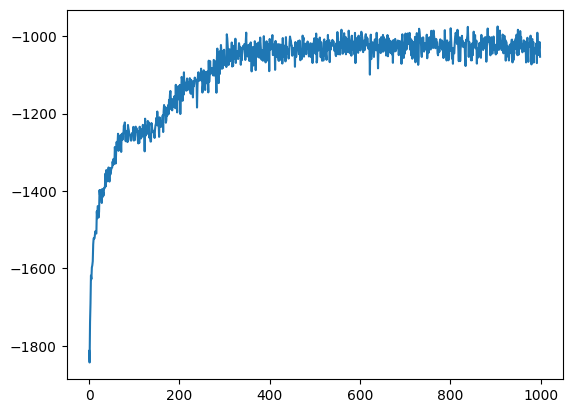

In [22]:
# As clearly visible dozen is read as doken.
plt.plot(scores)
plt.show()